<code>calculate_RMSE_MAE_S2S_models_all_days.ipynb</code>.  This notebook just quickly calculates the RMSE, MAE, and raw error for each S2S model's actual SIE forecasts and anomalous SIE forecasts.  See <code>Calculate_RMSE_MAE_S2S_model_all_seas_COMMON_PERIOD.ipynb</code> for a nicer example. 

<b>inputs:</b><br>
<li>  model name (ecmwf,ukmo,ncep,metreofr) </li>
<li>  seas_str [string for season; ALL if we want to do full year]</li>
<li>  seas_sel [months of season; empty if we want to do full year] </li>
<li>  vrile_thresh [threshhold at which VRILE is estimated </li>
<li>  thresh_str [string for VRILE threshhold] </li>


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os

## Functions

<li>1) Load model netCDF files, combine with CTRL, and use common reforecast period. <br>
if NCEP, use entire period </li>
<li> 2) Add aggregate regions </li>
<li> 3) Create climatology--model: calculate date of year for valid date, lead time in weeks.<br>
    Group by region, lead time, and valid date of year <br>
    Average climatology based on day of year and lead time in weeks--use <code>transform</code> to create <code>SIE_clim</code>.<br> 
    Subtract <code>SIE_clim</code> from <code>SIE</code><br> </li>
<li> 4) Create observed climatology </li>
<li> 5) Calculate errors: as a function of region, valid date, and lead time. Want to output: <br>
    Raw error (for bias) <br>
    Mean absolute error <br>
    RMSE <br>
    For both SIE and anomalous SIE </li>

Load the netCDF files for our specific model from <code>/home/disk/sipn/nicway</code>.  We want the control runs too.  Then, select only the common reforecast period (1999-01-01 to 2014-12-31), and add the control run to the rest of the output. <br>
NOTE: for NCEP, since the reforecast period is short (ends in 2011), we will just use the entire period. 

In [2]:
def load_model(model_name):
    # Paths for perturb and control runs
    filepath = '/home/disk/sipn/nicway/data/model/{model_name}/reforecast/sipn_nc_agg/'.format(model_name=model_name)
    filepath_ctrl = '/home/disk/sipn/nicway/data/model/{model_name}/reforecast.control/sipn_nc_agg/'.format(model_name=model_name)
    # Open both with xarray
    filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
    filenames_ctrl = xr.open_mfdataset(filepath_ctrl+'/*.nc',combine='by_coords')
    print(filenames)
    # load SIE
    SIE = filenames.Extent
    SIE_ctrl = filenames_ctrl.Extent
    # Add coordinate to ensemble dimension for SIE_ctrl so we can combine with SIE
    SIE_ctrl.coords['ensemble'] = xr.DataArray([len(SIE.ensemble)],
                                               dims='ensemble', coords={'ensemble':[len(SIE.ensemble)]})
    # Use common reforecast period for all models EXCEPT NCEP
    if model_name != 'ncep':
        common_start = '1999-01-01'
        common_end = '2014-12-31'
        # Select only common reforecast period (full period for NCEP)
        SIE = SIE.sel(init_time=slice(common_start,common_end))
        SIE_ctrl = SIE_ctrl.sel(init_time=slice(common_start,common_end))
        # Remove repeated indices in CTRL
        _,init_ind_c = np.unique(SIE_ctrl['init_time'],return_index=True)
        SIE_ctrl = SIE_ctrl.isel(init_time=init_ind_c)
    elif model_name == 'ncep':
        #
        _,init_ind = np.unique(SIE['init_time'],return_index=True)
        SIE = SIE.isel(init_time=init_ind)
        _,init_ind_c = np.unique(SIE_ctrl['init_time'],return_index=True)
        SIE_ctrl = SIE_ctrl.isel(init_time=init_ind_c)
        
    
    # Concatenate the two
    SIE = xr.concat([SIE,SIE_ctrl],dim='ensemble')
    
    return SIE

We want to create a few aggregate regions from the NSIDC MASIE regions (more at: https://nsidc.org/data/masie/browse_regions) since some regions are so small. We're going to combine the following: <br>
<li> Kara and Laptev Seas (<code>region_KL</code>)</li>
<li> Barents, Kara and Laptev Seas (<code>region_BKL</code>)</li>
<li> East Siberian, Beaufort, and Chukchi Seas (<code>region_EBC</code>)</li>
<li> Atlantic (Baffin Bay and East Greenland Sea) (<code>region_ATL</code>)</li>
<li> East Siberian, Beaufort, Chukchi, Laptev Seas (<code>region_EBCL</code>)</li>


In [3]:
def create_aggregate_regions(SIE_data):
    nregions = SIE_data['nregions']
    region_names = SIE_data['region_names']
    # Get corresponding indices for each of our aggregate regions
    region_KL = nregions[region_names.isin(['Kara Sea','Laptev Sea'])]
    region_BKL = nregions[region_names.isin(['Barents Sea','Kara Sea','Laptev Sea'])]
    region_EBC = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea'])]
    region_ATL = nregions[region_names.isin(['Baffin Bay','East Greenland Sea'])]
    region_EBCL = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea','Laptev Sea'])]
    # Select each aggregate region, add them together, and add the 'nregions' dimension back; concatenate all aggregates 
    SIE_agg = xr.concat([SIE_data.sel(nregions=region_KL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_BKL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBC).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_ATL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBCL).sum(dim='nregions').expand_dims(dim='nregions')],dim='nregions')
    # Add coordinates to nregions.  Start at 20 to make a clear separation from original NSIDC regions
    SIE_agg = SIE_agg.assign_coords(nregions=[20,21,22,23,24])
    # Add region names
    region_names_extra = ['Kara-Laptev Sea','Barents-Kara-Laptev Sea','East Siberian-Beaufort-Chukchi Sea',
                      'Atlantic','East Siberian-Beaufort-Chukchi-Laptev Sea']
    SIE_agg["region_names"] = ("nregions",region_names_extra)
    #SIE
    SIE_data = xr.concat([SIE_data,SIE_agg],dim='nregions')
    return(SIE_data)

Create climatology for model output based on region, day of year, and lead time.  Get month-day for valid dates (don't use dayofyear because of leap days).  Since our forecasts are not initialized every day, we will do two versions--one where we keep each lead time separate, and one where we group our lead time climatology based on week instead of day (which is more supported in the literature). 

In [4]:
def create_model_climatology(SIE,week_length):
    # Add valid date in %m-%d format
    SIE['valid date of yr'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')
    # Determine lead time as a function of weeks instead of days
    SIE_df_weekly = SIE.copy()
    SIE_df_weekly['lead time (weeks)'] = SIE_df['lead time (days)'].values.astype('timedelta64[D]')/pd.Timedelta(week_length,'D')
    SIE_df_weekly['lead time (weeks)'] = SIE_df_weekly['lead time (weeks)'].apply(np.floor)
    # Group by region, lead time, and valid day of year. Use .transform('mean') so that our climatology has the 
    # same shape as the original input dataframe (so we can just subtract SIE_clim from SIE easily at the end)
    SIE['SIE clim'] = SIE.groupby(['region','lead time (days)','valid date of yr'])['SIE'].transform('mean')
    SIE_df_weekly['SIE clim'] = SIE_df_weekly.groupby(['region','lead time (weeks)','valid date of yr'])['SIE'].transform('mean')

    SIE['SIE anom'] = SIE['SIE'] - SIE['SIE clim']
    SIE_df_weekly['SIE anom'] = SIE_df_weekly['SIE'] - SIE_df_weekly['SIE clim']
    return(SIE,SIE_df_weekly)

Create climatology for the observations.  This is easier, we just need to get the day of year (month-day) for each observation, take the mean, and then subtract the annual cycle from our full dataset. 

In [5]:
def create_obs_climatology(SIE):
    # Add valid date in %m-%d format
    SIE['valid day of year'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')
    # Group by region and day of year and take the mean. Use transform to make the output match the dataframe instead
    # of creating a multi-index
    SIE['SIE clim'] = SIE.groupby(['region','valid day of year'])['SIE'].transform('mean')
    # And simply subtract SIE_clim from actual SIE
    SIE['SIE anom'] = SIE['SIE'] - SIE['SIE clim']
    return SIE

Calculate raw error, mean absolute error, and RMSE.  These calculations will be a function of region and lead time.  See nice notebook for equations for RMSE and MAE

In [6]:
def calculate_errors(model_SIE,obs_SIE):
    model_SIE['lead days'] = model_SIE['lead time (days)'].dt.days
    # Group by region, valid date, and lead time (for model)
    SIE_obsx = obs_SIE.groupby(['region','valid date'])['SIE','SIE clim','SIE anom'].mean()
    # First calculate raw model error (we'll also group by init time so we can save that for calculating other stuff)
    SIE_model_raw = model_SIE.groupby(['region','valid date','lead days','init date'])['SIE','SIE clim','SIE anom'].mean()
    SIE_raw_error = SIE_model_raw[['SIE','SIE anom']] - SIE_obsx[['SIE','SIE anom']]
    SIE_raw_error = SIE_raw_error.dropna(how='all')
    # Now, we'll do MAE and RMSE (we don't care about the date of initialization)
    SIE_modelx = model_SIE.groupby(['region','valid date','lead days'])['SIE','SIE clim','SIE anom'].mean()
    SIE_diff = SIE_modelx[['SIE','SIE anom']] - SIE_obsx[['SIE','SIE anom']]
    # Square errors to get RMSE. get absolute value of errors for MAE
    SIE_diff = SIE_diff.dropna(how='all')
    SIE_diff = SIE_diff.rename(columns={'SIE':'SIE raw error','SIE anom':'SIE anom raw error'})
    SIE_diff[['SIE sq error','SIE anom sq error']] = SIE_diff**2
    # Now, average over all valid dates and take the square root. 
    SIE_errors = SIE_diff[['SIE sq error','SIE anom sq error']].mean(level=(0,2))**0.5
    # Absolute value, then average over all valid dates to get the MAE
    SIE_errors[['SIE MAE','SIE anom MAE']] = SIE_diff[['SIE raw error','SIE anom raw error']].abs().mean(level=(0,2))
    SIE_errors = SIE_errors.rename(columns={'SIE sq error':'SIE RMSE','SIE anom sq error':'SIE anom RMSE'})
    return(SIE_raw_error,SIE_errors)
    

In [7]:
model_name = 'ecmwf'
seas_str = 'ALL'
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
obs_name = 'NSIDC_0079'
WEEKLY = False

Load model output for our desired model

In [8]:
SIE = load_model(model_name)
print('loaded ',model_name)

<xarray.Dataset>
Dimensions:       (ensemble: 10, fore_time: 46, init_time: 2080, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * ensemble      (ensemble) int32 0 1 2 3 4 5 6 7 8 9
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 44 days 45 days
  * init_time     (init_time) datetime64[ns] 1998-08-06 ... 2018-08-01
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(10, 1, 46, 15), meta=np.ndarray>
loaded  ecmwf


Create aggregate regions that combine some of the NSIDC-MASIE regions

In [9]:
SIE = create_aggregate_regions(SIE)
print('combined regions')

combined regions


In [10]:
SIE

<xarray.DataArray 'Extent' (ensemble: 11, init_time: 1664, fore_time: 46, nregions: 20)>
dask.array<concatenate, shape=(11, 1664, 46, 20), dtype=float64, chunksize=(10, 1, 46, 15), chunktype=numpy.ndarray>
Coordinates:
  * init_time     (init_time) datetime64[ns] 1999-01-03 ... 2014-12-31
  * ensemble      (ensemble) int64 0 1 2 3 4 5 6 7 8 9 10
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 44 days 45 days
    region_names  (nregions) object 'panArctic' ... 'East Siberian-Beaufort-Chukchi-Laptev Sea'
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 ... 13 14 15 20 21 22 23 24

Now, take the ensemble mean and get lead time in days

In [11]:
SIE_ens_mean = SIE.mean(dim='ensemble')
regions = SIE.region_names
lead_days = SIE.fore_time.dt.days

Convert to dataframe because I like Pandas

In [12]:
SIE_df = SIE_ens_mean.to_dataframe().reset_index()

Calculate the date for forecasts by adding the <code>fore_time</code> to <code>init_time</code>. Rename some columns to make life easier

In [13]:
SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
SIE_df = SIE_df.rename(columns={'region_names':'region',
                           'fore_time':'lead time (days)',
                           'init_time':'init date',
                           'Extent':'SIE'})

Create climatology for model output.  Decide how long we want weeks to be for weekly climatology (default is 7 days)

In [14]:
week_length = 7
SIE_df,SIE_df_weekly = create_model_climatology(SIE_df,7)
print('model climatology created')

model climatology created


Load observations.  NSIDC_0079 is NASA Bootstrap, NSIDC_0081 is NASA team

In [15]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs and convert obs to Pandas dataframe

In [16]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})

Calculate our observed climatology 

In [17]:
obs_SIE = create_obs_climatology(obs_SIE)
print('observed climatology created')

observed climatology created


If we want to do a single season only, now we'll drop our data down to those months.  If we're doing full-year, keep everything

In [18]:
if seas_str != 'ALL':
    SIE_df = SIE_df[pd.to_datetime(SIE_df['valid date']).dt.month.isin(seas_sel)]
    obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.month.isin(seas_sel)]
print('season selected')

season selected


Finally, calculate the raw errors, the MAE, and the RMSE.

In [19]:
SIE_df_weekly['lead days'] = SIE_df_weekly['lead time (weeks)']
SIE_df

,init date,lead time (days),nregions,region,SIE,valid date,valid date of yr,SIE clim,SIE anom
0,1999-01-03,0 days,99,panArctic,12.877095,1999-01-03,01-03,12.305199,0.571896
1,1999-01-03,0 days,2,Sea of Okhotsk,0.582058,1999-01-03,01-03,0.442489,0.139569
2,1999-01-03,0 days,3,Bering,0.460486,1999-01-03,01-03,0.477781,-0.017295
3,1999-01-03,0 days,4,Hudson Bay,1.081344,1999-01-03,01-03,1.075383,0.005961
4,1999-01-03,0 days,5,St John,0.059987,1999-01-03,01-03,0.024223,0.035764
...,...,...,...,...,...,...,...,...,...
1530875,2014-12-31,45 days,20,Kara-Laptev Sea,1.662060,2015-02-14,02-14,1.654915,0.007145
1530876,2014-12-31,45 days,21,Barents-Kara-Laptev Sea,2.346988,2015-02-14,02-14,2.273067,0.073922
1530877,2014-12-31,45 days,22,East Siberian-Beaufort-Chukchi Sea,2.974176,2015-02-14,02-14,2.974391,-0.000216
1530878,2014-12-31,45 days,23,Atlantic,2.011355,2015-02-14,02-14,1.936100,0.075255


In [20]:
if WEEKLY == True:
    clim_freq_str = 'WEEKLY'
    SIE_df_weekly['lead days'] = SIE_df_weekly['lead time (weeks)']
    SIE_raw_err,SIE_errors = calculate_errors(SIE_df_weekly,obs_SIE)
else:
    clim_freq_str = 'DAILY'
    SIE_raw_err,SIE_errors = calculate_errors(SIE_df,obs_SIE)
print('errors calculated')

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


errors calculated


Get difference between model and obs standard deviation

In [44]:
obs_STD = obs_SIE.groupby(['region',pd.to_datetime(obs_SIE['valid date']).dt.month])['SIE','SIE clim','SIE anom'].std()
model_STD = SIE_df_weekly.groupby(['lead days','region',pd.to_datetime(SIE_df_weekly['valid date']).dt.month])['SIE','SIE clim',
                                                                                                         'SIE anom'].std()


/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Save files!

In [23]:
fdir = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/{model_name}/'.format(model_name=model_name)
if not os.path.exists(fdir):
    os.makedirs(fdir)
fname_save_raw = fdir+'RAW_err_{model_name}_months{seas_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,clim_freq_str=clim_freq_str)
fname_save_RMSE = fdir+'RMSE_MAE_{model_name}_months{seas_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,clim_freq_str=clim_freq_str)
SIE_raw_err.to_csv(fname_save_raw)
SIE_errors.to_csv(fname_save_RMSE)
print('files saved')

files saved


In [45]:
fname_save_std_error = fdir+'STD_err_{model_name}_months{seas_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=model_name,
                                             seas_str=seas_str,clim_freq_str=clim_freq_str)
model_STD.to_csv(fname_save_std_error)
#
fname_obs_save_std_error = fdir+'STD_err_OBS{model_name}_months{seas_str}_model_clim_freq_{clim_freq_str}.csv'.format(model_name=obs_name,
                                             seas_str=seas_str,clim_freq_str=clim_freq_str)
obs_STD.to_csv(fname_obs_save_std_error)

In [25]:
SIE_raw_err

SIE  SIE anom
region    valid date lead days init date                     
Atlantic  1999-01-03 0         1999-01-03 -0.110369  0.214202
          1999-01-04 1         1999-01-03 -0.076445  0.240323
          1999-01-05 2         1999-01-03 -0.098926  0.208814
          1999-01-06 3         1999-01-03 -0.103905  0.198957
          1999-01-07 0         1999-01-07 -0.238176  0.089804
...                                             ...       ...
panArctic 2015-02-10 45        2014-12-27 -0.908551  0.323976
          2015-02-11 42        2014-12-31 -0.904626  0.350175
          2015-02-12 43        2014-12-31 -0.899852  0.362550
          2015-02-13 44        2014-12-31 -0.890755  0.375159
          2015-02-14 45        2014-12-31 -0.917359  0.361879

[1530880 rows x 2 columns]

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


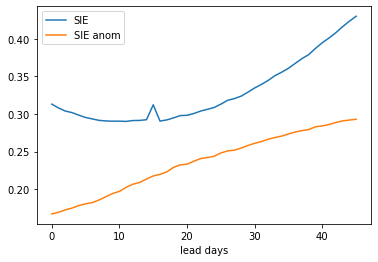

In [26]:
foo = SIE_raw_err.xs('panArctic').reset_index()
import scipy.stats as stats
foo2 = foo.groupby(['lead days'])['SIE','SIE anom'].std()
foo2.plot()